<a href="https://colab.research.google.com/github/adhish-bahl/2347203_NNDL_Lab/blob/main/2347203_Lab9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Importing Libraries**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [3]:
torch.manual_seed(42)

#### **Laoding Dataset**

In [4]:
transform = transforms.Compose([transforms.ToTensor(), lambda x: x.view(-1), lambda x: x / 255.0])

mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.24MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 153kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.21MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### **Spliting training data into train and validation sets**

In [5]:
train_size = int(0.8 * len(mnist))
val_size = len(mnist) - train_size
mnist_train, mnist_val = random_split(mnist, [train_size, val_size])

train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
val_loader = DataLoader(mnist_val, batch_size=64, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

#### **Check the data shapes**

In [6]:

input_size = mnist[0][0].shape[0]
print(f"Input size: {input_size}")

Input size: 784


#### **Define the RBM Model**

In [7]:
class RBM(torch.nn.Module):
    def __init__(self, visible_units, hidden_units):
        super(RBM, self).__init__()
        self.visible_units = visible_units
        self.hidden_units = hidden_units

        self.weights = torch.nn.Parameter(torch.randn(hidden_units, visible_units) * 0.01)
        self.v_bias = torch.nn.Parameter(torch.zeros(visible_units))
        self.h_bias = torch.nn.Parameter(torch.zeros(hidden_units))

    def sample_h(self, v):
        prob_h = torch.sigmoid(torch.matmul(v, self.weights.t()) + self.h_bias)
        return prob_h, torch.bernoulli(prob_h)

    def sample_v(self, h):
        prob_v = torch.sigmoid(torch.matmul(h, self.weights) + self.v_bias)
        return prob_v, torch.bernoulli(prob_v)

    def forward(self, v):
        _, h_sample = self.sample_h(v)
        _, v_reconstructed = self.sample_v(h_sample)
        return v_reconstructed

    def contrastive_divergence(self, v, k=1):
        v_ = v
        for _ in range(k):
            prob_h, h = self.sample_h(v_)
            prob_v, v_ = self.sample_v(h)
        return v, v_

    def training_step(self, v, k=1):
        v0, vk = self.contrastive_divergence(v, k)
        prob_h0, h0 = self.sample_h(v0)
        prob_hk, hk = self.sample_h(vk)

        positive_grad = torch.matmul(h0.t(), v0)
        negative_grad = torch.matmul(hk.t(), vk)

        self.weights.grad = -(positive_grad - negative_grad) / v.size(0)
        self.v_bias.grad = torch.mean(v0 - vk, dim=0)
        self.h_bias.grad = torch.mean(h0 - hk, dim=0)

        return torch.mean(torch.sum((v0 - vk) ** 2, dim=1))

hidden_units = 128
rbm = RBM(visible_units=input_size, hidden_units=hidden_units)
optimizer = torch.optim.SGD([rbm.weights, rbm.v_bias, rbm.h_bias], lr=0.1)


#### **Train RBM**

In [8]:
epochs = 10
k = 1

for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        v, _ = batch
        v = v.view(v.size(0), -1)
        loss = rbm.training_step(v, k)
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 1/10, Loss: 563893.9707
Epoch 2/10, Loss: 587398.1797
Epoch 3/10, Loss: 587398.1792
Epoch 4/10, Loss: 587398.1816
Epoch 5/10, Loss: 587398.1786
Epoch 6/10, Loss: 587398.1797
Epoch 7/10, Loss: 587398.1790
Epoch 8/10, Loss: 587398.1807
Epoch 9/10, Loss: 587398.1791
Epoch 10/10, Loss: 587398.1791


#### **Extract Features**

In [9]:
def get_hidden_representation(data_loader, rbm):
    features, labels = [], []
    for batch in data_loader:
        v, label = batch
        v = v.view(v.size(0), -1)
        prob_h, _ = rbm.sample_h(v)
        features.append(prob_h.detach().numpy())
        labels.append(label.numpy())
    return np.vstack(features), np.hstack(labels)

train_features, train_labels = get_hidden_representation(train_loader, rbm)
test_features, test_labels = get_hidden_representation(test_loader, rbm)

print(f"Train features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")


Train features shape: (48000, 128)
Test features shape: (10000, 128)


#### **Visualize RBM Weights**

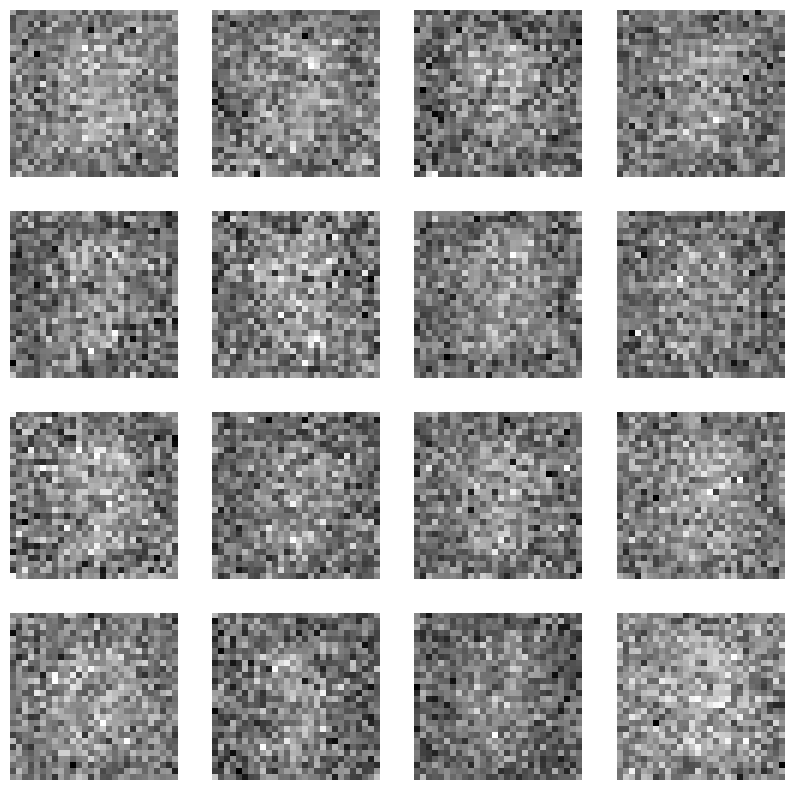

In [10]:
weights = rbm.weights.detach().numpy()
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(weights[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()


#### **Train and Evaluate Classifier**

In [11]:
classifier = LogisticRegression(max_iter=1000)
classifier.fit(train_features, train_labels)

test_preds = classifier.predict(test_features)
accuracy = accuracy_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(test_labels, test_preds))


Accuracy: 0.1135
F1 Score: 0.0231

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.11      1.00      0.20      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.11     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.11      0.02     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### **Analysis**

In [12]:
raw_train, raw_train_labels = next(iter(DataLoader(mnist_train, batch_size=len(mnist_train))))
raw_train = raw_train.view(raw_train.size(0), -1).numpy()

raw_test, raw_test_labels = next(iter(DataLoader(mnist_test, batch_size=len(mnist_test))))
raw_test = raw_test.view(raw_test.size(0), -1).numpy()

classifier_raw = LogisticRegression(max_iter=1000)
classifier_raw.fit(raw_train, raw_train_labels)

raw_preds = classifier_raw.predict(raw_test)
raw_accuracy = accuracy_score(raw_test_labels, raw_preds)
raw_f1 = f1_score(raw_test_labels, raw_preds, average='weighted')

print(f"Raw Pixel Data - Accuracy: {raw_accuracy:.4f}, F1 Score: {raw_f1:.4f}")


Raw Pixel Data - Accuracy: 0.7648, F1 Score: 0.7514
